# Best and Worst Results

Pulling out the best and worst results graph maker to here so it's cleaner

In [1]:
import analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import wandb
import yaml
from constants import DATASET_NAMES, MAX_SIZES

In [2]:
# Load the data
api = wandb.Api()
datasets = list(MAX_SIZES.keys())
train_data = utils.get_data(api, "train", datasets)
metric_data = utils.get_data(api, "metrics", datasets)
data = metric_data.merge(train_data, on=["dataset_name", "model_name", "n_samples"])

# Read in imagenet validation accuracies
with open("../configs/scores_imagenet1k.yaml") as f:
    imagenet = yaml.safe_load(f)
imagenet = [
    {"model_name": key, "imagenet-validation": {"score": imagenet[key]}}
    for key in imagenet.keys()
]
imagenet = pd.DataFrame(imagenet)

# Merge in imagenet val acc
data = data.merge(imagenet, on="model_name")

# Multiply test accuracy by 100 for regret computation
data["test_accuracy"] = data["test_accuracy"] * 100

In [3]:
# Compute all correlations accross different dataset sizes
group_data = data.groupby(["dataset_name", "n_samples", "n_metric_samples"])
metrics = ["renggli", "LogME", "n_pars", "imagenet-validation"]
corr_tables = []
for met in metrics:
    corr_tables.append(analysis.get_correlations(group_data, met))

In [97]:
# Compute all regrets across different dataset sizes
regret_tables = []
for met in metrics:
    regret_tables.append(analysis.get_regrets(group_data, met, 1))

In [4]:
metric_names = {}
metric_names["renggli"] = ("Renggli", 0)
metric_names["LogME"] = ("LogME", 1)
metric_names["n_pars"] = ("N. Params", 2)
metric_names["imagenet-validation"] = ("ImageNet Acc.", 3)
metric_names

{'renggli': ('Renggli', 0),
 'LogME': ('LogME', 1),
 'n_pars': ('N. Params', 2),
 'imagenet-validation': ('ImageNet Acc.', 3)}

In [5]:
# Extract correlation from correlation tables
for metric in metric_names.keys():
    corr_tables[metric_names[metric][1]][metric] = [
        v[0] for v in corr_tables[metric_names[metric][1]][metric].values
    ]

In [6]:
corr_tables[0]

,dataset,n_samples,n_metric_samples,renggli
0,VG Faucet,500,500,0.440102
1,VG Faucet,1000,500,0.711565
2,VG Faucet,1000,1000,0.540392
3,VG Faucet,2303,500,0.090185
4,VG Faucet,2303,1000,0.277018
...,...,...,...,...
58,Oxford Pets,1000,500,0.248862
59,Oxford Pets,1000,1000,0.354885
60,Oxford Pets,4803,500,0.397940
61,Oxford Pets,4803,1000,0.361219


In [7]:
def get_best_worst_metric(correlations, metric):
    """Return the best and worst results for a given metric, return a triple of
        (dataset, n_samples, n_metric_samples)

    Args:
        correlations: correlation results
    """
    return (
        (
            correlations[correlations[metric] == correlations[metric].max()],
            correlations[metric].max(),
        ),
        (
            correlations[correlations[metric] == correlations[metric].min()],
            correlations[metric].min(),
        ),
    )

In [18]:
def get_dataset_name_from_dataset(dataset):
    for pair in list(DATASET_NAMES.items()):
        if pair[1] == dataset:
            return pair[0]

In [106]:
def extract_best_worst_raw_data(run_data, best_run):
    return run_data[
        (
            run_data["dataset_name"]
            == get_dataset_name_from_dataset(best_run["dataset"].values[-1])
        )
        & (run_data["n_samples"] == best_run["n_samples"].values[-1])
        & (run_data["n_metric_samples"] == best_run["n_metric_samples"].values[-1])
    ]

In [209]:
def plot_best_worst_metric(correlations, run_data, ylim=(50, 85), fig_size=(15, 30)):
    """Plot all the pairs of best and worst metrics for correlations"""
    fig, ax = plt.subplots(4, 2, figsize=fig_size)
    for idx, metric in enumerate(metric_names.keys()):
        (best_run, best_corr), (worst_run, worst_corr) = get_best_worst_metric(
            correlations[metric_names[metric][1]], metric
        )
        best_data = extract_best_worst_raw_data(run_data, best_run)
        worst_data = extract_best_worst_raw_data(run_data, worst_run)

        # Plot scatter plots
        best_scores = np.asarray([v["score"] for v in best_data[metric].values])
        best_acc = best_data["test_accuracy"].values
        ax[idx, 0].scatter(best_scores, best_acc)

        worst_scores = np.asarray([v["score"] for v in worst_data[metric].values])
        worst_acc = worst_data["test_accuracy"].values
        ax[idx, 1].scatter(worst_scores, worst_acc)

        # Plot max points
        best_picked_idx = np.argmax(best_scores)
        best_trained_idx = np.argmax(best_acc)
        ax[idx, 0].scatter(
            best_scores[best_picked_idx],
            best_acc[best_picked_idx],
            marker="P",
            s=100,
            label="Metric Selecte Model",
        )
        ax[idx, 0].scatter(
            best_scores[best_trained_idx],
            best_acc[best_trained_idx],
            marker="P",
            s=100,
            label="Fine-Tuning Selected Model",
        )

        worst_picked_idx = np.argmax(worst_scores)
        worst_trained_idx = np.argmax(worst_acc)
        ax[idx, 1].scatter(
            worst_scores[worst_picked_idx],
            worst_acc[worst_picked_idx],
            marker="P",
            s=100,
            label="Metric Selecte Model",
        )
        ax[idx, 1].scatter(
            worst_scores[worst_trained_idx],
            worst_acc[worst_trained_idx],
            marker="P",
            s=100,
            label="Fine-Tuning Selected Model",
        )

        # Axis scale
        # ax[idx, 0].set_ylim(ylim[0], ylim[1])
        # ax[idx, 1].set_ylim(ylim[0], ylim[1])

        # Axis labels
        ax[idx, 0].set_xlabel(f"{metric_names[metric][0]} Metric Score")
        ax[idx, 1].set_xlabel(f"{metric_names[metric][0]} Metric Score")
        ax[idx, 0].set_ylabel("Post Fine-Tuning Test Accuracy")
        ax[idx, 1].set_ylabel("Post Fine-Tuning Test Accuracy")

        # Plot Titles
        btitle1 = f"Best {metric_names[metric][0]} Result vs. Test Acc."
        btitle2 = f"\n{best_run['dataset'].values[-1]}, "
        btitle3 = f"{best_run['n_samples'].values[-1]} training images"
        btitle4 = f", {best_run['n_metric_samples'].values[-1]} metric images"
        if metric == "n_pars" or metric == "imagenet-validation":
            btitle4 = " "
        btitle5 = f"\ncorrelation = {np.around(best_corr, 2)}"
        ax[idx, 0].set_title(
            btitle1 + btitle2 + btitle3 + btitle4 + btitle5, fontsize=16
        )

        wtitle1 = f"Worst {metric_names[metric][0]} Result vs. Test Acc."
        wtitle2 = f"\n{worst_run['dataset'].values[-1]}, "
        wtitle3 = f"{worst_run['n_samples'].values[-1]} training images"
        wtitle4 = f", {worst_run['n_metric_samples'].values[-1]} metric images"
        if metric == "n_pars" or metric == "imagenet-validation":
            wtitle4 = " "
        wtitle5 = f"\ncorrelation = {np.around(worst_corr, 2)}"
        ax[idx, 1].set_title(
            wtitle1 + wtitle2 + wtitle3 + wtitle4 + wtitle5, fontsize=16
        )
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=15, bbox_to_anchor=(1.25, 0.95))
    fig.tight_layout()

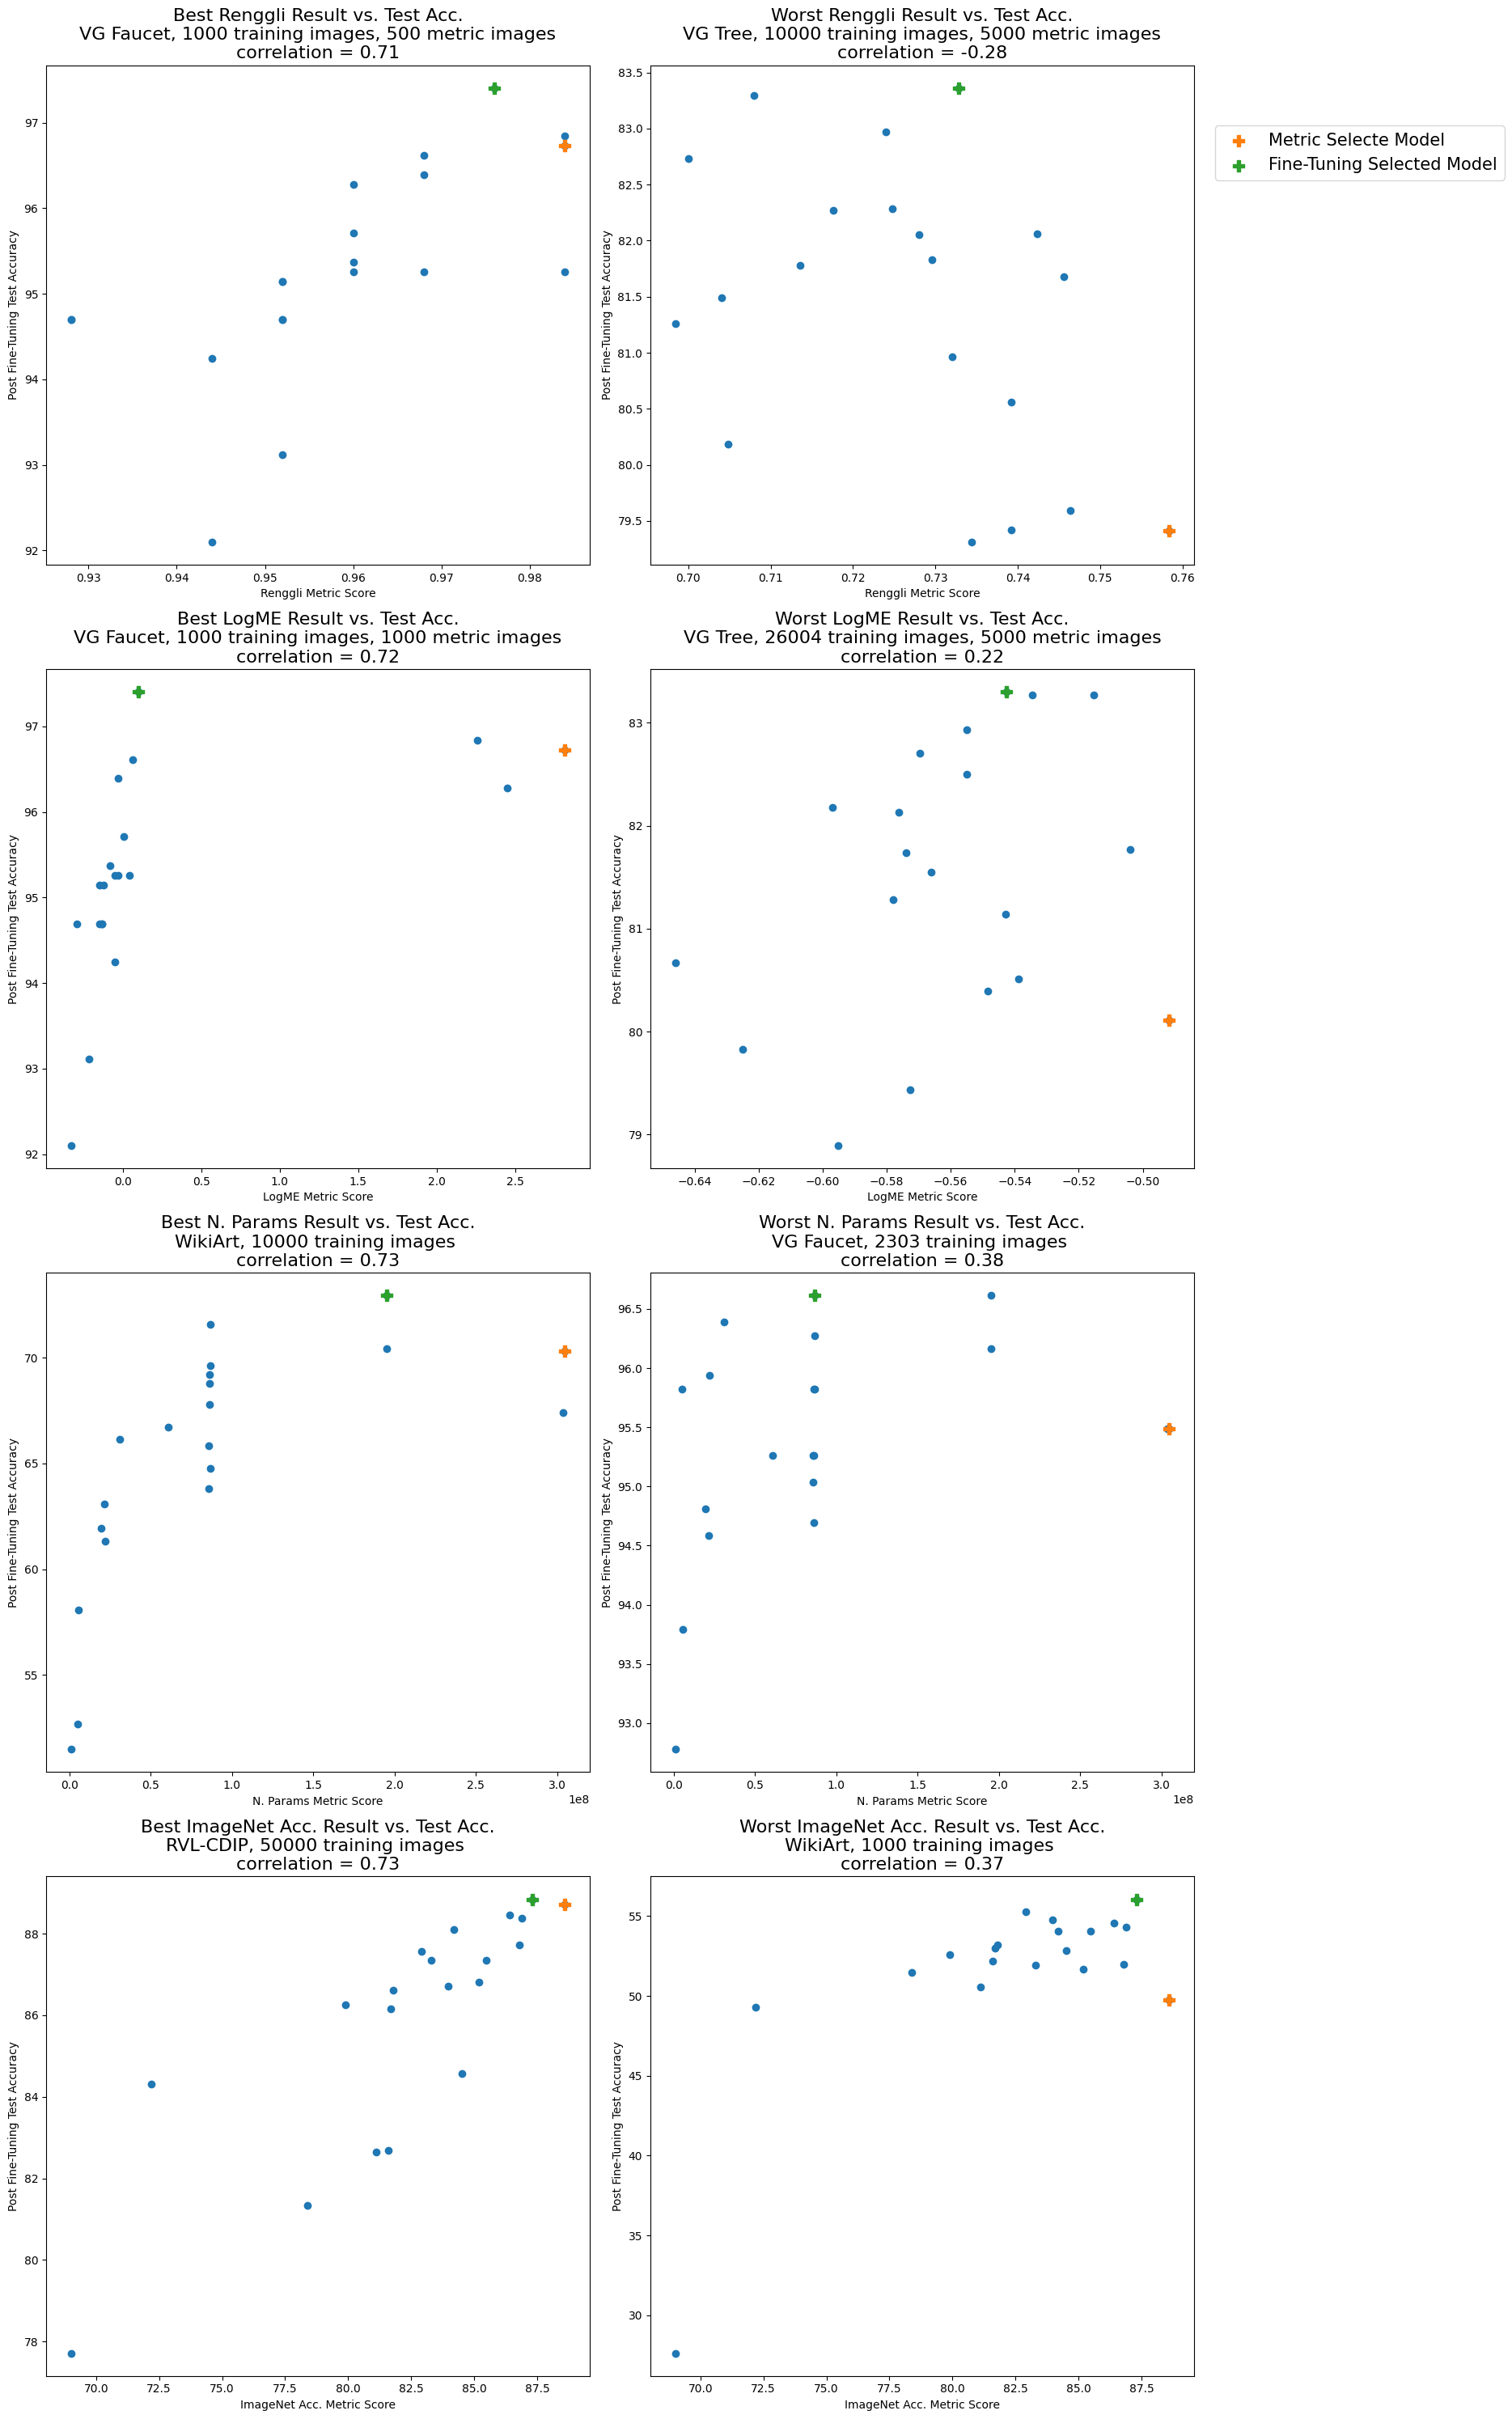

In [210]:
plot_best_worst_metric(corr_tables, data, ylim=(0.0, 100.0))